# QDrift

In [1]:
from trotter.hamsimtrotter import AlgorithmHamSimTrotter
from qDrift.hamsimqDrift import AlgorithmHamSimqDrift
from pytket.circuit import Circuit
from openfermion.utils.operator_utils import count_qubits

from utils.func import *
from utils.term_grouping import *
from utils.min_clique import *
from utils.hamlib import *
from utils.evol_real import *
from utils.plot import *
from utils.driver import *
from utils.JW import *

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

def gen_sys_param(n=10, sample_steps=10):
    global t_max
    global initial_state_circ
    global n_qdrift_steps
    global sample_space

    t_max=2
    initial_state_circ = Circuit(n)
    n_qdrift_steps = sample_steps
    sample_space = np.arange(0,sample_steps+1,1)

# Expectation

In [3]:
# gen_sys_param()
# n_qdrift_steps = 100
# drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,Heisenberg_d,Heisenberg_c,Heisenberg[0],t_max,n_qdrift_steps,t)
# drift_time_evolution.Drift_exp()
# trotter_time_evolution_cheat = AlgorithmHamSimTrotter(initial_state_circ,Heisenberg[0],measurements,t_max,n_qdrift_steps,t)
# trotter_time_evolution_cheat._trotter_step_cheat(exps='Energy')
# drift_time_evolution.execute(list(trotter_time_evolution_cheat._real_measurement.values()), color='purple')

# Error bound

In [4]:
# gen_sys_param()
# error = 1
# n_qdrift_steps = 3
# while error > 1e-4:
#     U_sims = []
#     gen_sys_param()
#     time_evolution = AlgorithmHamSimqDrift(initial_state_circ,Heisenberg_d,Heisenberg_c,Heisenberg[0],t_max,n_qdrift_steps,t)
#     time_evolution.Drift_exp()
#     U_sim = time_evolution.execute()
#     U_sims.append(U_sim)
#     trotter_time_evolution = AlgorithmHamSimTrotter(initial_state_circ,Heisenberg[0],measurements,t_max,n_qdrift_steps,t)
#     U = trotter_time_evolution.execute(color='green', cheat=False, plot=False)
#     error = calculate_error(U_sims, U)
#     print('step:',n_qdrift_steps,'error:',error)
#     if error < precision:
#         print('Congratulations!')
#     n_qdrift_steps *= 10

'''
step: 3 error: 1.8507102429864286
step: 30 error: 1.749055560834051
step: 300 error: 1.300882374374903
step: 3000 error: 0.7472272607324455
step: 30000 error: 0.1812082026023719
step: 300000 error: 0.059744391798576615
'''

'\nstep: 3 error: 1.8507102429864286\nstep: 30 error: 1.749055560834051\nstep: 300 error: 1.300882374374903\nstep: 3000 error: 0.7472272607324455\nstep: 30000 error: 0.1812082026023719\nstep: 300000 error: 0.059744391798576615\n'

# Term grouping

In [2]:
H_matrix, ops_dict, ops2, H_ops_orig, H_coeff_orig = generate_dict(LiH())
min_clique_cover = create_clique(ops2, ops_dict)
H_coeff = []
for i,clique in enumerate(min_clique_cover):
    H_coeff.append([])
    for op in clique:
        H_coeff[i].append(ops_dict[op])

In [9]:
gen_sys_param(sample_steps = 5)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,min_clique_cover,H_coeff,t_max,n_qdrift_steps)
particle_no, idx = drift_time_evolution.Drift_exp(track_no_paulistr=True)

In [13]:
dict_term = {paulistr: count for paulistr, count in zip([get_dict_str(min_clique_cover[id][0]) for id in list(set(list(idx)))], [list(idx).count(i) for i in list(set(list(idx)))])}

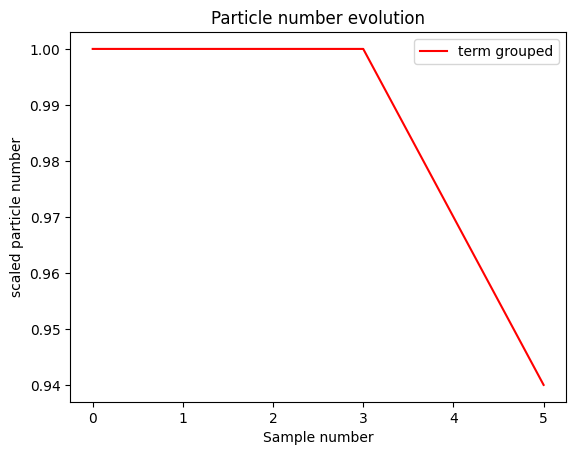

In [17]:
particle_number(np.arange(6),particle_no, label='term grouped', color='r')

In [12]:
gen_sys_param(sample_steps = drift_time_evolution.terms)
drift_time_evolution_orig = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig,H_coeff_orig,t_max,n_qdrift_steps)
particle_no_orig, idx_orig = drift_time_evolution_orig.Drift_exp()

In [18]:
dict_orig = {paulistr: count for paulistr, count in zip([get_dict_str(list(ops_dict.keys())[id]) for id in list(set(list(idx_orig)))], [list(idx_orig).count(i) for i in list(set(list(idx_orig)))])}

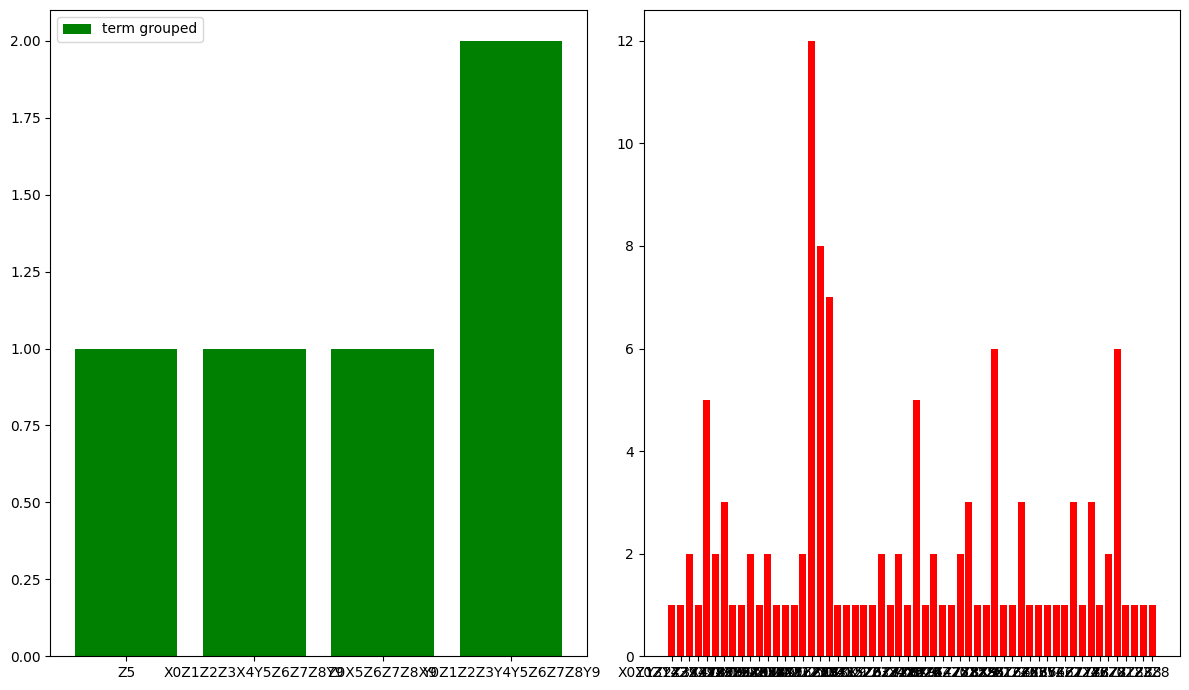

In [19]:
hist([dict_term, dict_orig])

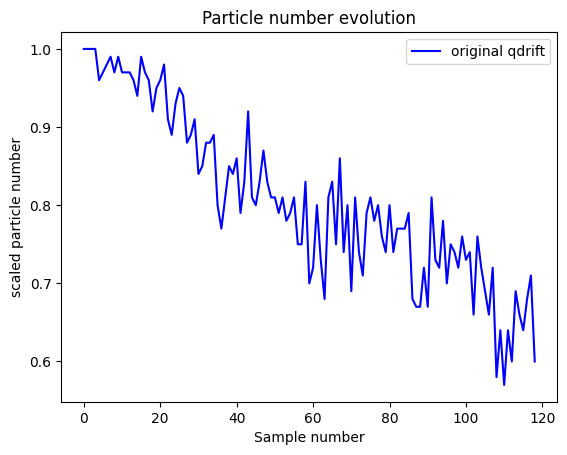

In [20]:
particle_number(sample_space,particle_no_orig, label='original qdrift', color='b')

In [63]:
# compare spectral error
gen_sys_param(sample_steps = 10)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,min_clique_cover,H_coeff,t_max,n_qdrift_steps)
Us, V = drift_time_evolution.Drift_exp(track_no_paulistr=True)

In [65]:
gen_sys_param(sample_steps=drift_time_evolution.terms)
drift_time_evolution_orig = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig,H_coeff_orig,t_max,n_qdrift_steps)
Us_orig, _ = drift_time_evolution_orig.Drift_exp()
Us_orig = section(V,Us_orig)

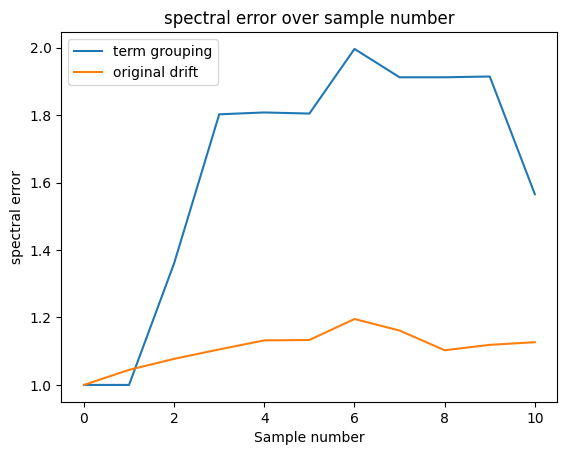

In [66]:
gen_sys_param(sample_steps = 10)
U = U_exc(drift_time_evolution._initial_state,n_qdrift_steps, t_max, H_matrix)
compare_spectral_error(sample_space, U, Us, Us_orig)

# Particle number grouping

In [3]:
particle_group_coeff = list(set(list(ops_dict.values())))
p_coeff = [[co] for co in particle_group_coeff]
particle_group = []
for coeff in particle_group_coeff:
    particle_group.append([]) 
    for strs in list(ops_dict.keys()):
        if ops_dict[strs]==coeff:
            particle_group[particle_group_coeff.index(coeff)].append(strs) 

In [52]:
gen_sys_param(sample_steps = 10)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,particle_group,p_coeff,t_max,n_qdrift_steps)
Us, V = drift_time_evolution.Drift_exp(track_no_paulistr=True)

In [47]:
def section(term_list, Us_orig):
    U = [Us_orig[0]]
    count = 0
    for i in range(len(term_list)):
        count += len(term_list[i])
        U.append(Us_orig[count])
    return U

In [53]:
gen_sys_param(sample_steps = drift_time_evolution.terms)
drift_time_evolution_orig = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig,H_coeff_orig,t_max,n_qdrift_steps)
Us_orig, _ = drift_time_evolution_orig.Drift_exp()
Us_orig = section(V,Us_orig)

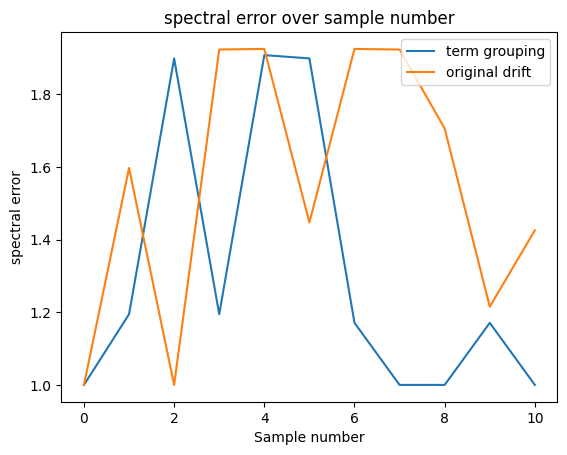

In [61]:
gen_sys_param(sample_steps = 10)
U = U_exc(drift_time_evolution._initial_state,n_qdrift_steps, t_max, H_matrix)
compare_spectral_error(sample_space, U, Us, Us_orig)

# Heisenberg group

In [2]:
H_matrix, H_ops_orig, H_coeff_orig, H_ops, H_coeff = Heisenberg(4,-1)

In [8]:
gen_sys_param(n=4,sample_steps=100)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,H_ops,H_coeff,t_max,n_qdrift_steps)
particle_no, idx = drift_time_evolution.Drift_exp(track_no_paulistr=True)

/Users/peteryang/Downloads/Hamiltonian-Decomposition/qDrift/hamsimqDrift.py:63: RuntimeWarning: invalid value encountered in double_scalars
  new_coeffs = [new_coeff*co/abs(co) for co in weights]


[['YYII', 'IYYI', 'IIYY', 'YIIY'], ['YYII', 'IYYI', 'IIYY', 'YIIY'], ['YYII', 'IYYI', 'IIYY', 'YIIY'], ['YYII', 'IYYI', 'IIYY', 'YIIY'], ['YYII', 'IYYI', 'IIYY', 'YIIY'], ['XXII', 'IXXI', 'IIXX', 'XIIX'], ['YYII', 'IYYI', 'IIYY', 'YIIY'], ['XXII', 'IXXI', 'IIXX', 'XIIX'], ['XXII', 'IXXI', 'IIXX', 'XIIX'], ['YYII', 'IYYI', 'IIYY', 'YIIY'], ['XXII', 'IXXI', 'IIXX', 'XIIX'], ['YYII', 'IYYI', 'IIYY', 'YIIY'], ['XXII', 'IXXI', 'IIXX', 'XIIX'], ['YYII', 'IYYI', 'IIYY', 'YIIY'], ['XXII', 'IXXI', 'IIXX', 'XIIX'], ['XXII', 'IXXI', 'IIXX', 'XIIX'], ['YYII', 'IYYI', 'IIYY', 'YIIY'], ['XXII', 'IXXI', 'IIXX', 'XIIX'], ['XXII', 'IXXI', 'IIXX', 'XIIX'], ['XXII', 'IXXI', 'IIXX', 'XIIX'], ['XXII', 'IXXI', 'IIXX', 'XIIX'], ['YYII', 'IYYI', 'IIYY', 'YIIY'], ['YYII', 'IYYI', 'IIYY', 'YIIY'], ['YYII', 'IYYI', 'IIYY', 'YIIY'], ['YYII', 'IYYI', 'IIYY', 'YIIY'], ['YYII', 'IYYI', 'IIYY', 'YIIY'], ['YYII', 'IYYI', 'IIYY', 'YIIY'], ['YYII', 'IYYI', 'IIYY', 'YIIY'], ['XXII', 'IXXI', 'IIXX', 'XIIX'], ['XXII', 'IXX

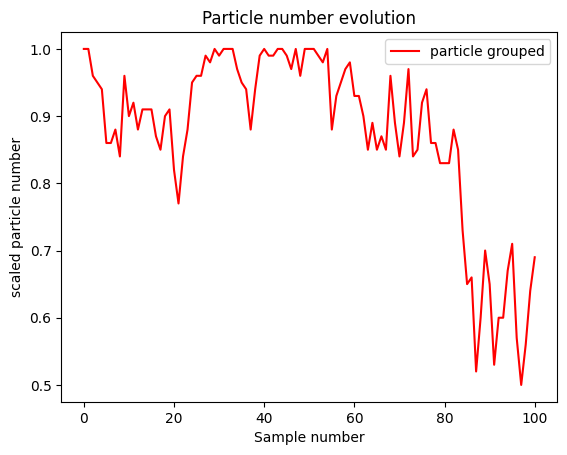

In [9]:
particle_number(sample_space ,particle_no, label='particle grouped', color='r')

In [6]:
gen_sys_param(n=4,sample_steps = 400)
drift_time_evolution_orig = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig,H_coeff_orig,t_max,n_qdrift_steps)
particle_no_orig, idx_orig = drift_time_evolution_orig.Drift_exp()

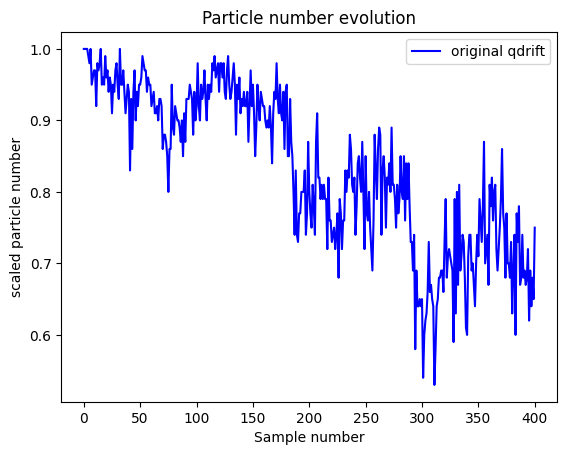

In [7]:
particle_number(sample_space,particle_no_orig, label='original qdrift', color='b')

# Transformation

In [2]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)
problem = driver.run()
fermionic_op = problem.hamiltonian.second_q_op()

/usr/local/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [ ]:
# from qiskit_nature.second_q.mappers import JordanWignerMapper
# mapper = JordanWignerMapper()
# qubit_jw_op = mapper.map(fermionic_op)
# print(qubit_jw_op)

In [9]:
H_matrix, ops_dict, ops2, H_ops_orig, H_coeff_orig = generate_dict(H())
H_matrix_r, ops_dict_r, ops2_r, H_ops_orig_r, H_coeff_orig_r = generate_dict(H_reduce())

In [4]:
from qiskit_nature.second_q.mappers import ParityMapper
mapper = ParityMapper(num_particles=problem.num_particles)
qubit_op = mapper.map(fermionic_op)
print(qubit_op)

-1.0523732457728596 * II
+ 0.3979374248431793 * IZ
- 0.3979374248431793 * ZI
- 0.011280104256235213 * ZZ
+ 0.18093119978423136 * XX


/usr/local/lib/python3.11/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


In [5]:
mapper_orig = ParityMapper()
qubit_op_orig = mapper_orig.map(fermionic_op)
print(qubit_op_orig)

-0.8105479805373275 * IIII
+ 0.1721839326191553 * IIIZ
- 0.22575349222402408 * IIZZ
+ 0.17218393261915538 * IZZI
- 0.22575349222402405 * ZZII
+ 0.12091263261776633 * IIZI
+ 0.16892753870087915 * IZZZ
+ 0.045232799946057854 * ZXIX
- 0.045232799946057854 * IXZX
- 0.045232799946057854 * ZXZX
+ 0.045232799946057854 * IXIX
+ 0.1661454325638242 * ZZIZ
+ 0.1661454325638242 * IZIZ
+ 0.17464343068300445 * ZZZZ
+ 0.12091263261776633 * ZIZI


In [21]:
gen_sys_param(n=2,sample_steps=300)
drift_time_evolution_r = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig_r,H_coeff_orig_r,t_max,n_qdrift_steps)
particle_no_r, idx_r = drift_time_evolution_r.Drift_exp(track_no_paulistr=True)

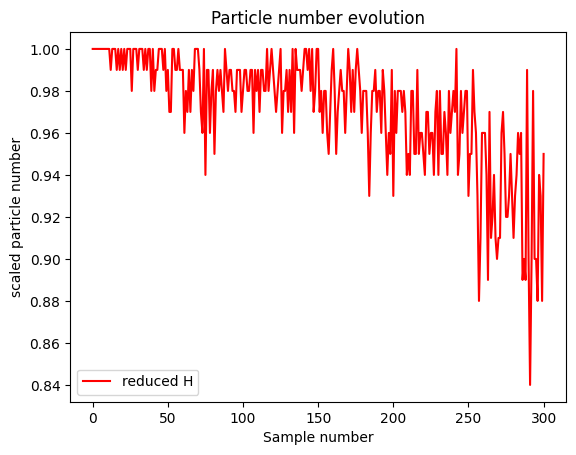

In [22]:
particle_number(sample_space ,particle_no_r, label='reduced H', color='r')

In [17]:
gen_sys_param(n=4,sample_steps=100)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig,H_coeff_orig,t_max,n_qdrift_steps)
particle_no, idx = drift_time_evolution.Drift_exp(track_no_paulistr=True)

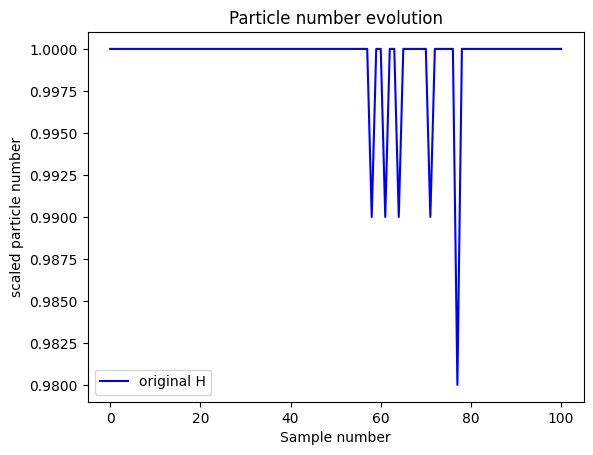

In [18]:
particle_number(sample_space ,particle_no, label='original H', color='b')

# Exact particle group

In [2]:
driver = PySCFDriver_custom()
driver.load_molecule(
    atom=[("H", [-0.02111417,0.8350417,1.47688078]),  # H stands for hydrogen element in water
          ("O", [0.0, 0.0, 0.0]),                     # O stands for oxygen element in water
          ("H", [-0.00201087,0.45191737,-0.27300254])],         # Geometry of H2O molecule
    basis="sto-3g",          # Basis set for quantum chemistry calculation
    multiplicity=1,          # Spin multiplicity for molecule, since the total spin of H2O is S=0，its spin multiplicity is 2S+1=1
    charge=0,                 # Total charge of molecule, since H2O is charge neutral, its charge=0
    unit="Angstrom"
)
driver.run_scf()             # Perform Hartree Fock calculation

# np.set_printoptions(precision=4, linewidth=150)

hpq = driver.get_onebody_tensor("int1e_kin") + driver.get_onebody_tensor("int1e_nuc")
vpqrs = driver.get_twobody_tensor()
# assert np.shape(hpq)==(7, 7)             # H2O has 7 orbitals when using STO-3G basis.
# assert np.shape(vpqrs)==(7, 7, 7, 7)

# print(hpq)
operator = get_molecular_hamiltonian(hpq,vpqrs,driver)
n_qubits = count_qubits(operator)
number, coulomb, excitation, no_excitation, double_excitation = JW_transformation(operator)

converged SCF energy = -73.9677038774737


In [16]:
# from openfermion import jordan_wigner
# jordan_wigner(operator)

In [3]:
def replace_Pauli_strings(n,list_paulis):
    identity = 'I'*n
    for p in list_paulis:
        pos = list(p)[0]
        pauli = list(p)[1]
        identity = identity[:pos] + pauli + identity[pos + 1:] 
    return identity

def convert_op_to_input(ops,n):
    tk_op = []
    tk_coeff = []
    for term, coeff in ops.terms.items():
        tk_op.append(replace_Pauli_strings(n,list(term)))
        tk_coeff.append(coeff)
    return tk_op[1:],tk_coeff[1:]


In [4]:
number_op, number_co = convert_op_to_input(number,n_qubits)
excitation_op, excitation_co = convert_op_to_input(excitation,n_qubits)
coulomb_op, coulomb_co = convert_op_to_input(coulomb,n_qubits)
no_excitation_op, no_excitation_co = convert_op_to_input(no_excitation,n_qubits)
double_excitation_op, double_excitation_co = convert_op_to_input(double_excitation,n_qubits)

In [5]:
gen_sys_param(n=n_qubits,sample_steps=30)
drift_time_evolution_parity = AlgorithmHamSimqDrift(initial_state_circ,[number_op,coulomb_op,excitation_op,no_excitation_op,double_excitation_op],[number_co,coulomb_co,excitation_co,no_excitation_co,double_excitation_co],t_max,n_qdrift_steps)
particle_no_p, idx_p, p = drift_time_evolution_parity.Drift_exp(track_no_paulistr=True)

In [6]:
print(idx_p, p)

[0 0 0 0 0 1 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0] [0.9186694014688874, 0.027498295093601778, 0.02632532078079732, 0.027498295093601778, 8.687563111640384e-06]


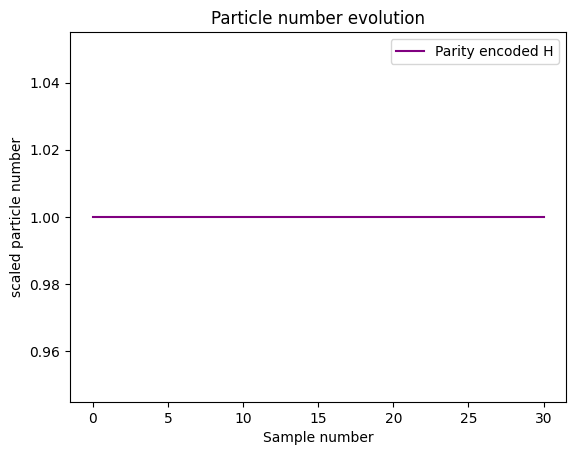

In [7]:
particle_number(sample_space ,particle_no_p, label='Parity encoded H', color='purple')